In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import sklearn.datasets as skds
from sklearn.datasets import fetch_openml

In [5]:
x, y = skds.fetch_openml("vehicleNorm", return_X_y=True)

In [6]:
print(x.shape)
print(y.shape)

(98528, 100)
(98528,)


In [7]:
print(y[0])
print([y[1000]])

-1
['1']


In [8]:
y[y==['1']] = 1
y[y==['-1']] = 0

In [9]:
print(y[0])
print([y[1000]])

0
[1]


In [10]:
x

<98528x100 sparse matrix of type '<class 'numpy.float64'>'
	with 9852800 stored elements in Compressed Sparse Row format>

In [11]:
x = x.toarray()
x

array([[ 0.67581 ,  2.5457  ,  0.144774, ..., -1.56049 , -0.400346,
        -0.396814],
       [ 0.032446,  0.049989, -0.015732, ..., -0.335038, -0.312752,
        -0.338297],
       [-0.078382, -0.068645, -0.0887  , ...,  0.344021,  0.271653,
        -0.589291],
       ...,
       [-0.303516, -0.244235, -0.261544, ..., -0.283664, -0.281754,
        -0.278929],
       [ 0.168386,  1.464081,  0.755141, ..., -0.475031, -0.455487,
        -0.592988],
       [ 2.048979,  2.5457  ,  1.361916, ..., -0.374222,  0.517196,
        -0.431849]])

In [12]:
X = StandardScaler().fit_transform(x)
print(X)

[[ 0.27076886  1.91647923 -0.38236881 ... -1.29247669 -0.13316891
  -0.13255143]
 [-0.37259841 -0.57924436 -0.54287562 ... -0.06701849 -0.04557447
  -0.07403413]
 [-0.48342698 -0.69787896 -0.61584399 ...  0.61204395  0.53883348
  -0.3250294 ]
 ...
 [-0.70856212 -0.87346984 -0.78868887 ... -0.01564423 -0.01457631
  -0.01466583]
 [-0.23665772  0.83485477  0.22800129 ... -0.2070122  -0.18831019
  -0.32872642]
 [ 1.64394484  1.91647923  0.83477936 ... -0.10620269  0.78437773
  -0.16758661]]


In [13]:
print(len(y))
print(sum(y))
print(len(y)-sum(y))
# 49264 positives and 24632 negatives for train, 24632 negatives for test

98528
49264
49264


In [14]:
x_neg=X[y==0]
x_pos=X[y==1]

In [15]:
print(x_neg.shape)
print(x_pos.shape)

(49264, 100)
(49264, 100)


In [16]:
np.random.shuffle(x_neg)
x_test=x_neg[0:24632]
x_train=x_neg[24632:49264]
x_train=np.concatenate((x_train,x_pos))

In [17]:
y_train=np.concatenate((np.zeros(24632),np.ones(49264)))
y_test=np.zeros(24632)

# Kraska Hash Model

In [18]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [19]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        model = Sequential()
        model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
        history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)

        print("Number of nodes: %d" %(init_size + (diff*i)))
        plt.plot(history.history['acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()
        plt.plot(history.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32

        m = int(model_size/10) + 1
        net_size = model_size + m

        bf=Kraska_Hash_BloomFilter(m,model)
        bf.add_init(x_train,y_train)
        fpr = fpr_kraska_hash(bf,x_test,y_test)

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

~~~~~~~~ Iteration 1 ~~~~~~~~ 

Number of nodes: 1


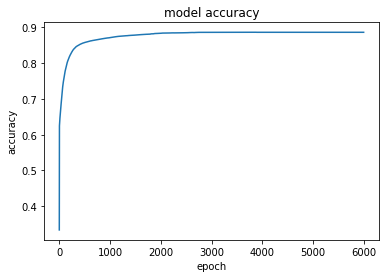

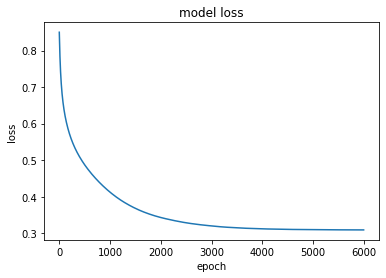

Size: 3626.000000 bits - FPR: 1.000000 



Number of nodes: 2


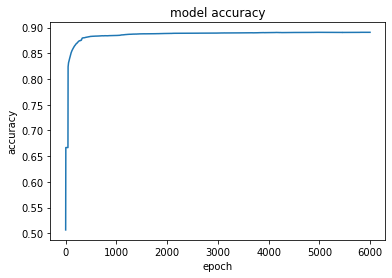

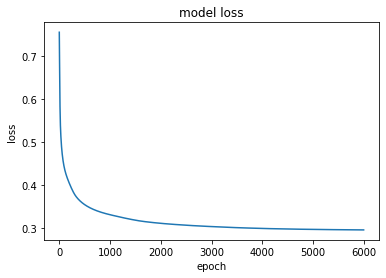

Size: 7217.000000 bits - FPR: 1.000000 



Number of nodes: 3


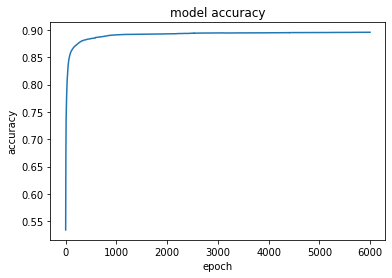

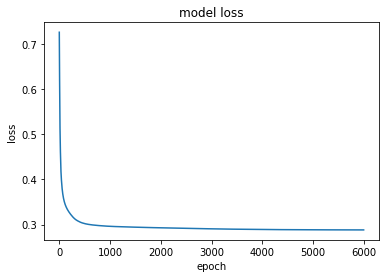

Size: 10807.000000 bits - FPR: 0.976047 



Number of nodes: 4


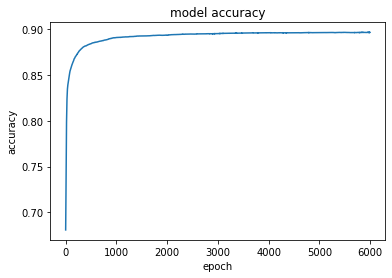

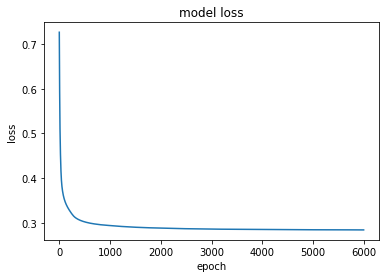

Size: 14397.000000 bits - FPR: 0.936099 



Number of nodes: 5


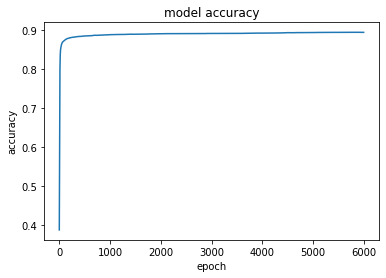

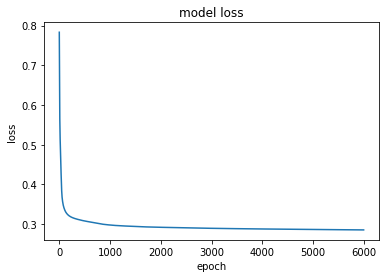

Size: 17988.000000 bits - FPR: 0.908980 



Number of nodes: 6


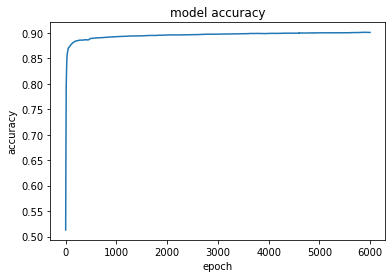

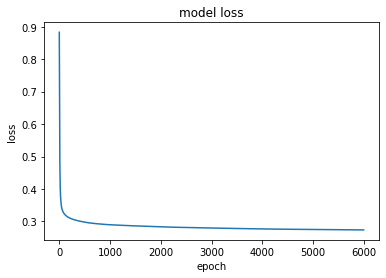

Size: 21578.000000 bits - FPR: 0.827704 



Number of nodes: 7


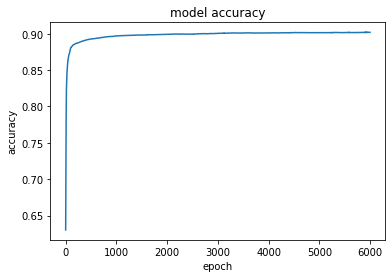

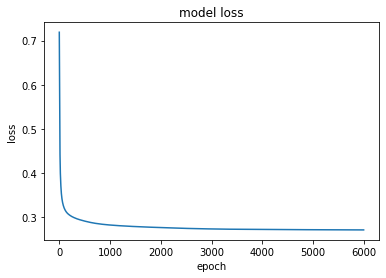

Size: 25169.000000 bits - FPR: 0.737252 



Number of nodes: 8


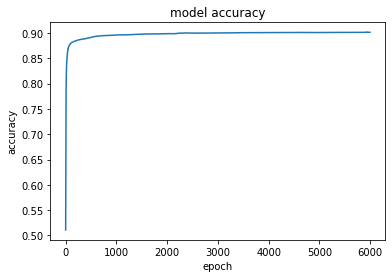

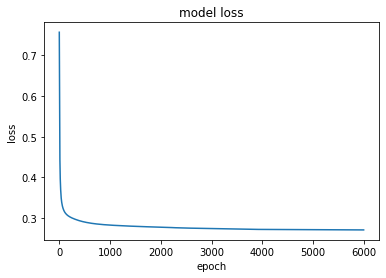

Size: 28759.000000 bits - FPR: 0.800219 



Number of nodes: 9


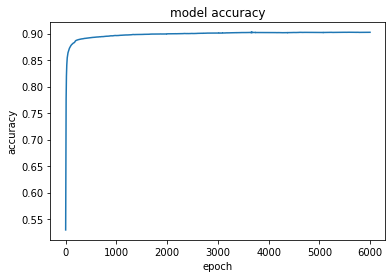

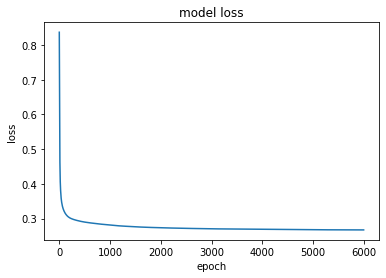

Size: 32349.000000 bits - FPR: 0.687439 



Number of nodes: 10


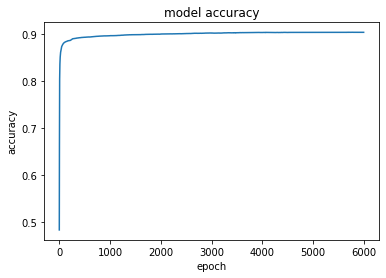

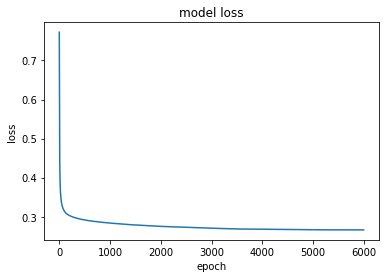

Size: 35940.000000 bits - FPR: 0.706276 



Number of nodes: 11


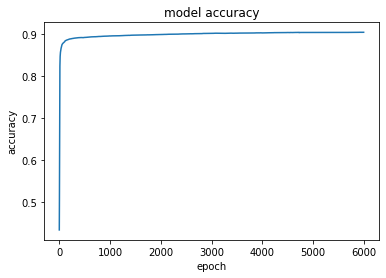

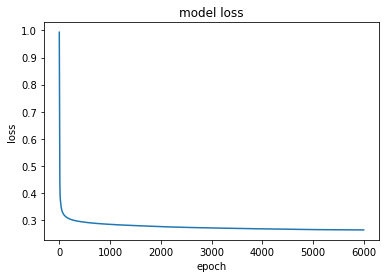

Size: 39530.000000 bits - FPR: 0.733193 



Number of nodes: 12


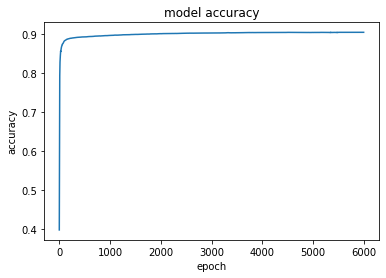

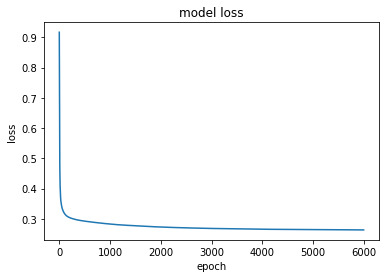

Size: 43121.000000 bits - FPR: 0.464152 



Number of nodes: 13


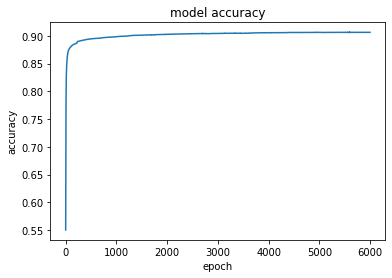

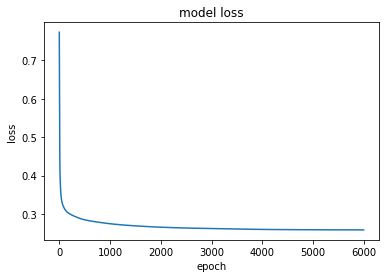

Size: 46711.000000 bits - FPR: 0.485507 



Number of nodes: 14


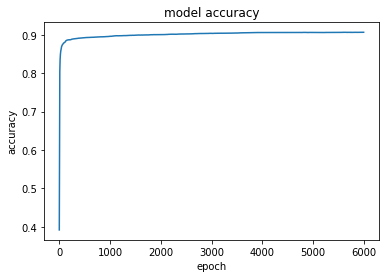

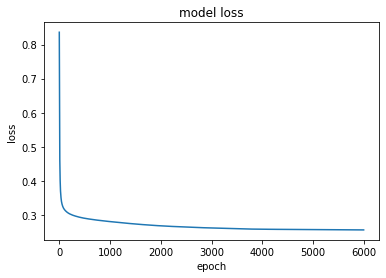

Size: 50301.000000 bits - FPR: 0.460499 



Number of nodes: 15


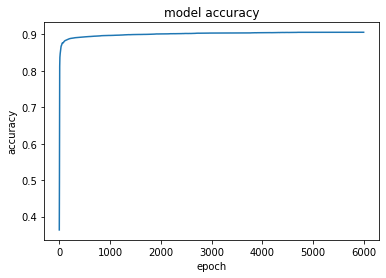

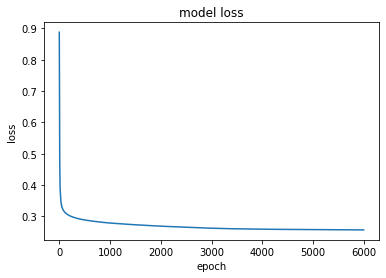

Size: 53892.000000 bits - FPR: 0.387057 



Number of nodes: 16


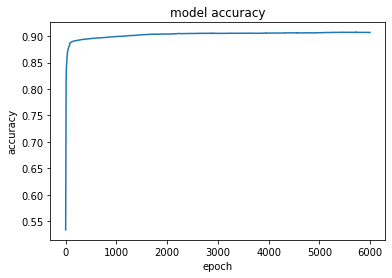

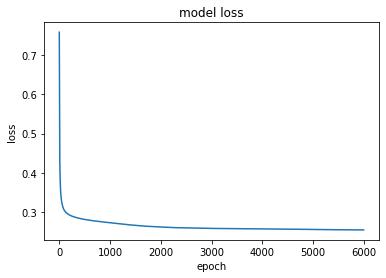

Size: 57482.000000 bits - FPR: 0.647044 



Number of nodes: 17


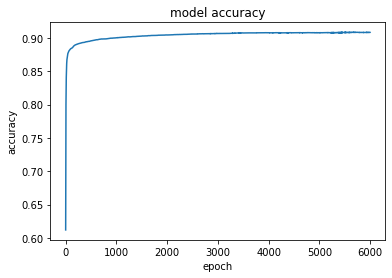

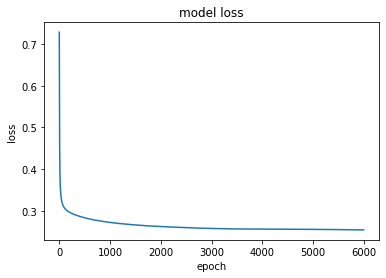

Size: 61073.000000 bits - FPR: 0.418845 



Number of nodes: 18


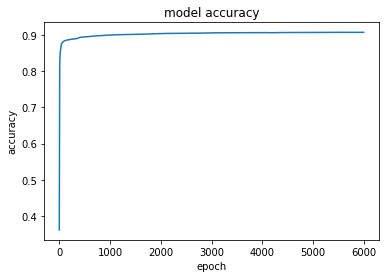

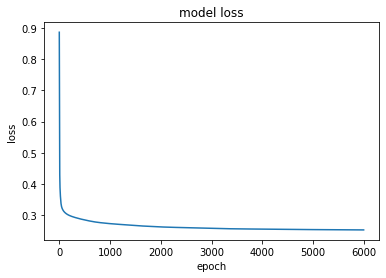

Size: 64663.000000 bits - FPR: 0.362943 



Number of nodes: 19


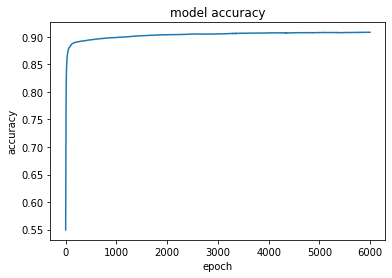

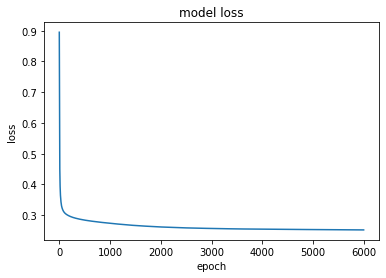

Size: 68253.000000 bits - FPR: 0.622524 



Number of nodes: 20


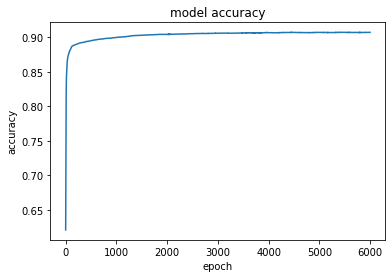

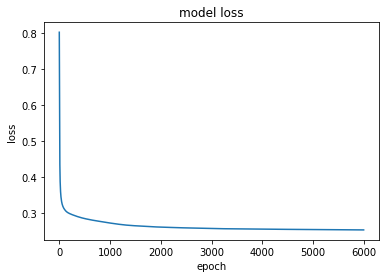

Size: 71844.000000 bits - FPR: 0.563779 



~~~~~~~~ Iteration 2 ~~~~~~~~ 

Number of nodes: 1


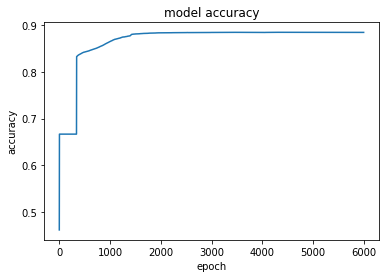

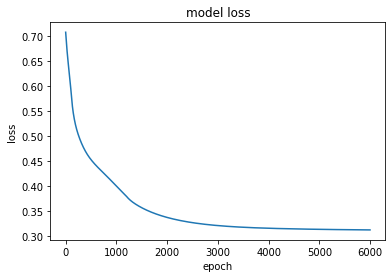

Size: 3626.000000 bits - FPR: 1.000000 



Number of nodes: 2


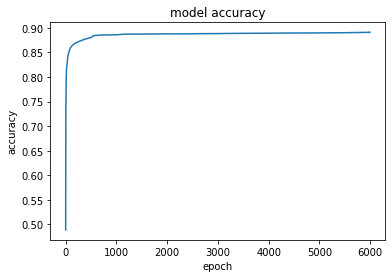

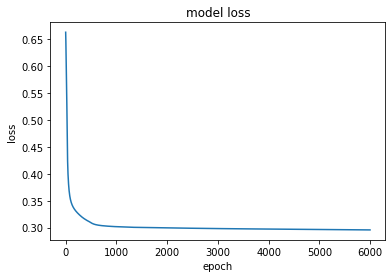

Size: 7217.000000 bits - FPR: 0.997280 



Number of nodes: 3


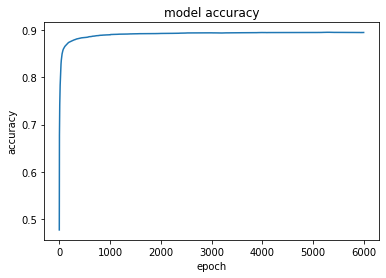

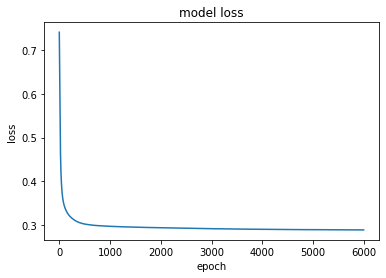

Size: 10807.000000 bits - FPR: 0.977590 



Number of nodes: 4


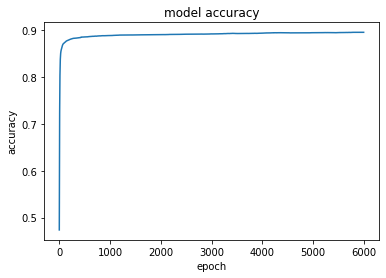

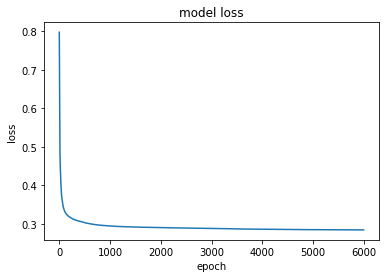

Size: 14397.000000 bits - FPR: 0.903378 



Number of nodes: 5


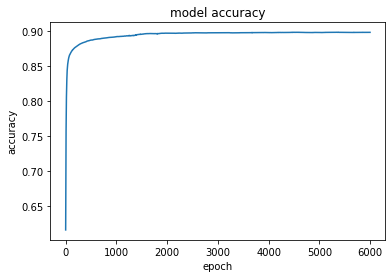

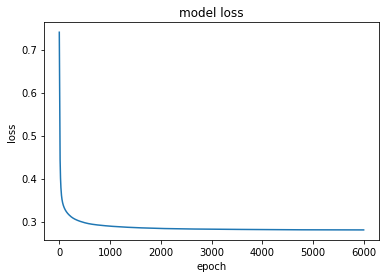

Size: 17988.000000 bits - FPR: 0.850073 



Number of nodes: 6


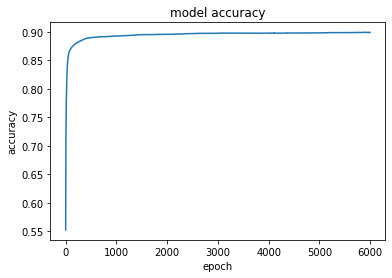

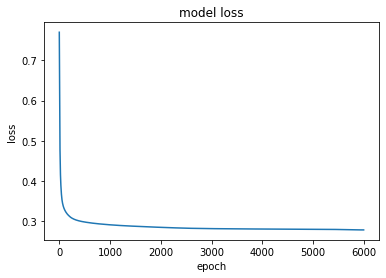

Size: 21578.000000 bits - FPR: 0.759175 



Number of nodes: 7


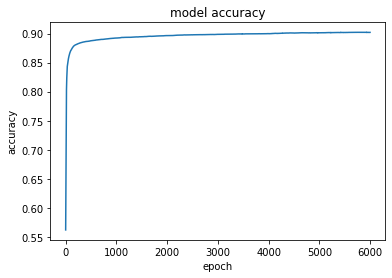

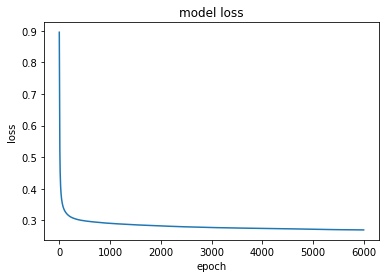

Size: 25169.000000 bits - FPR: 0.809029 



Number of nodes: 8


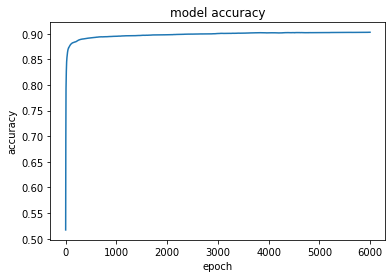

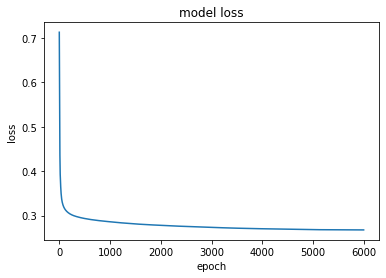

Size: 28759.000000 bits - FPR: 0.643878 



Number of nodes: 9


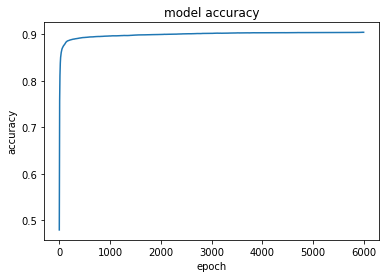

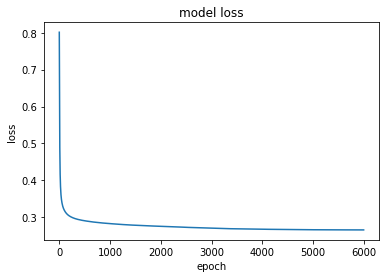

Size: 32349.000000 bits - FPR: 0.725114 



Number of nodes: 10


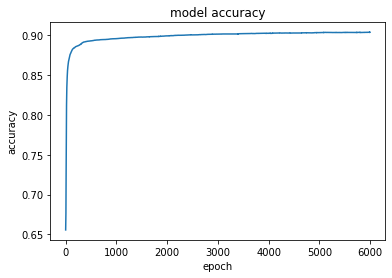

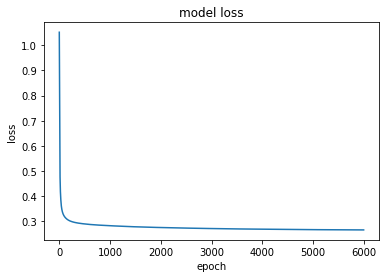

Size: 35940.000000 bits - FPR: 0.565484 



Number of nodes: 11


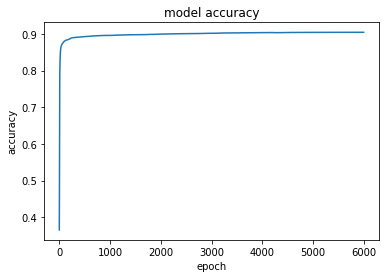

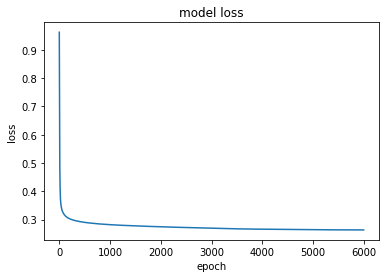

Size: 39530.000000 bits - FPR: 0.673271 



Number of nodes: 12


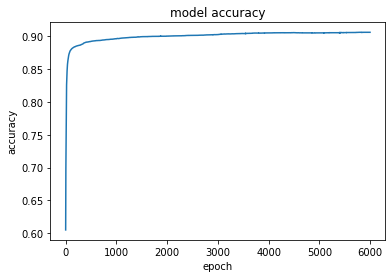

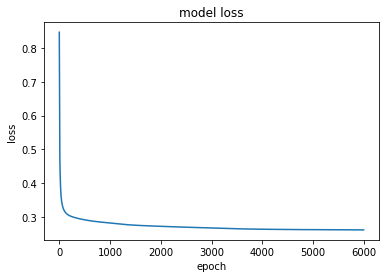

Size: 43121.000000 bits - FPR: 0.634581 



Number of nodes: 13


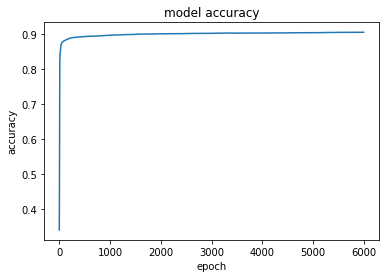

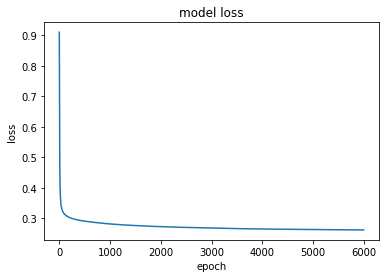

Size: 46711.000000 bits - FPR: 0.525252 



Number of nodes: 14


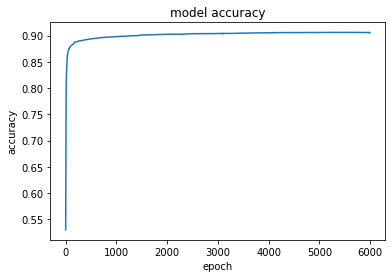

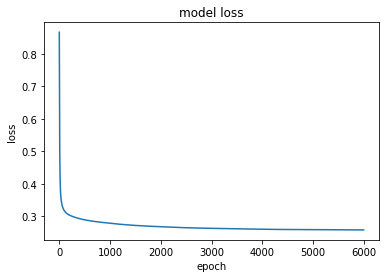

Size: 50301.000000 bits - FPR: 0.451770 



Number of nodes: 15


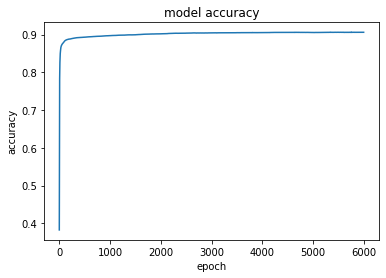

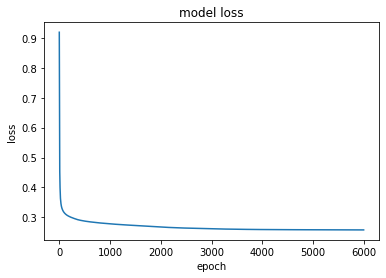

Size: 53892.000000 bits - FPR: 0.575999 



Number of nodes: 16


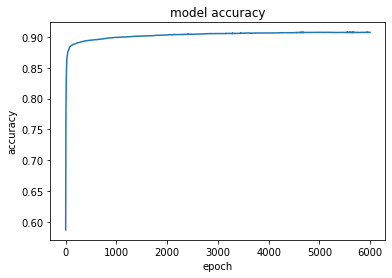

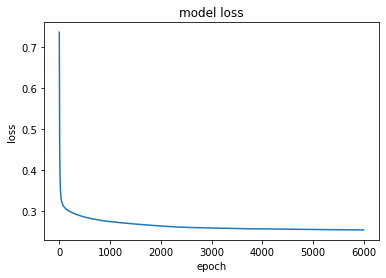

Size: 57482.000000 bits - FPR: 0.389250 



Number of nodes: 17


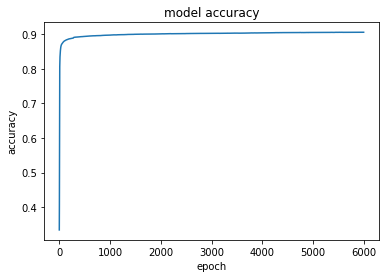

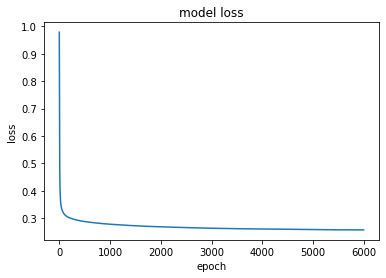

Size: 61073.000000 bits - FPR: 0.370128 



Number of nodes: 18


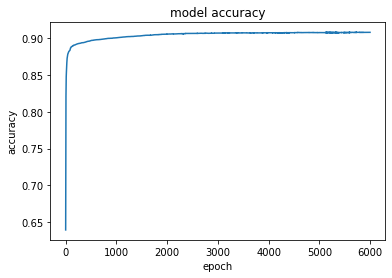

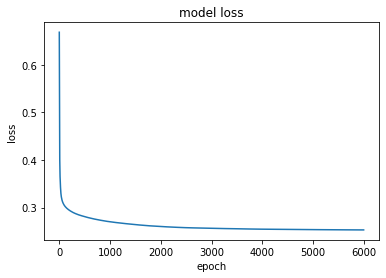

Size: 64663.000000 bits - FPR: 0.378248 



Number of nodes: 19


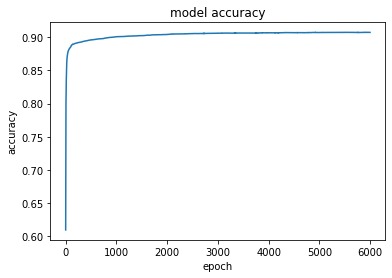

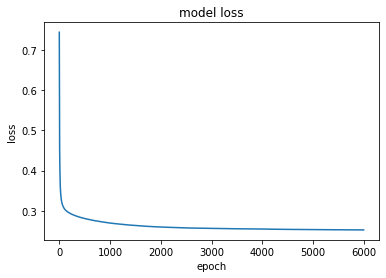

Size: 68253.000000 bits - FPR: 0.361846 



Number of nodes: 20


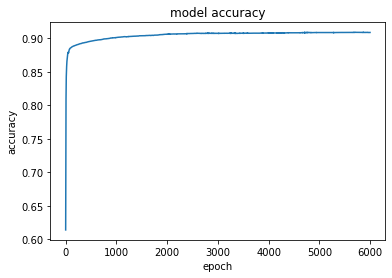

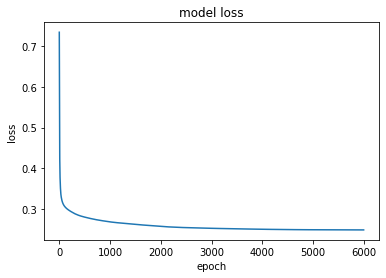

Size: 71844.000000 bits - FPR: 0.342725 



~~~~~~~~ Iteration 3 ~~~~~~~~ 

Number of nodes: 1


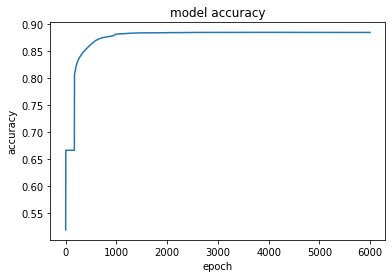

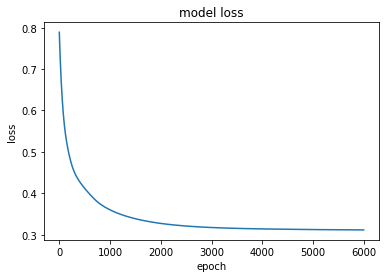

Size: 3626.000000 bits - FPR: 1.000000 



Number of nodes: 2


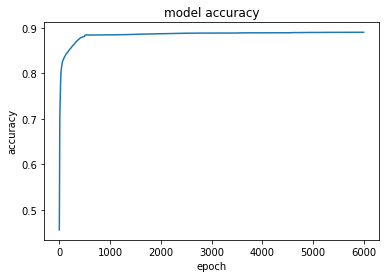

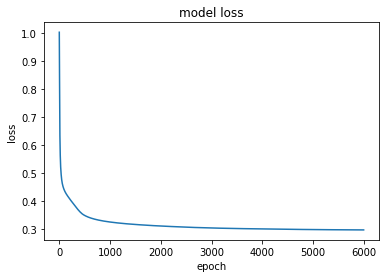

Size: 7217.000000 bits - FPR: 0.984532 



Number of nodes: 3


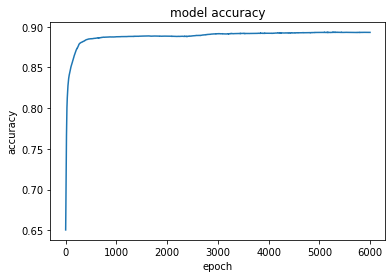

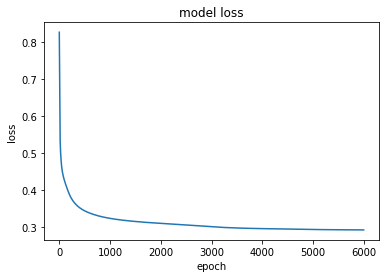

Size: 10807.000000 bits - FPR: 0.968212 



Number of nodes: 4


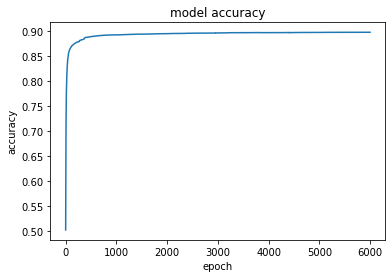

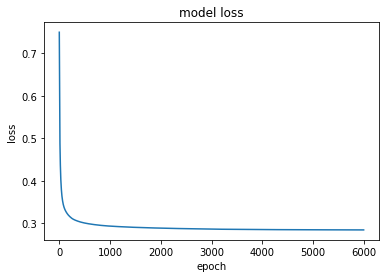

Size: 14397.000000 bits - FPR: 0.942067 



Number of nodes: 5


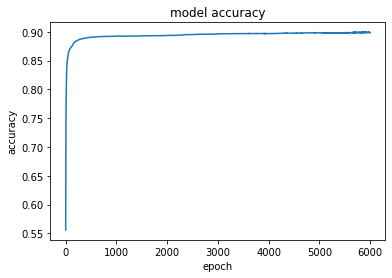

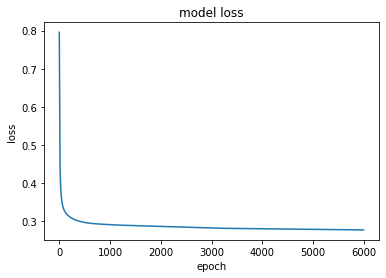

Size: 17988.000000 bits - FPR: 0.884703 



Number of nodes: 6


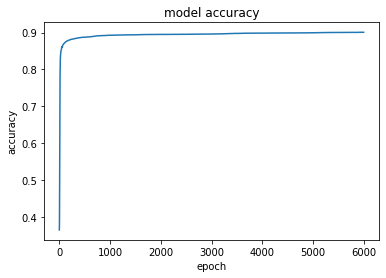

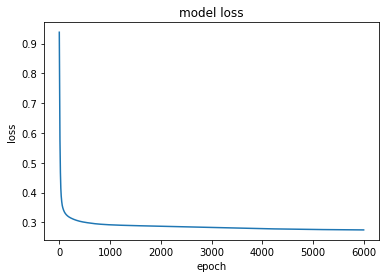

Size: 21578.000000 bits - FPR: 0.808014 



Number of nodes: 7


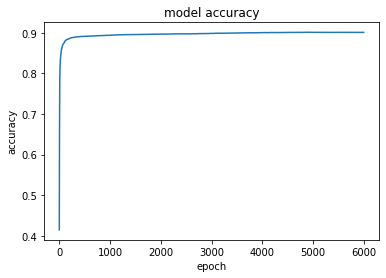

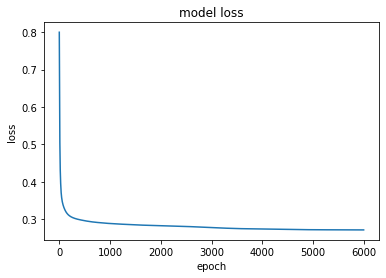

Size: 25169.000000 bits - FPR: 0.825390 



Number of nodes: 8


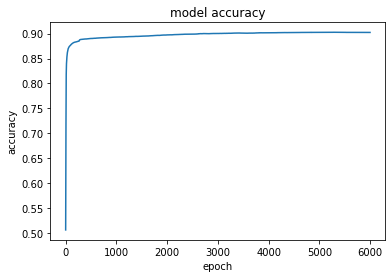

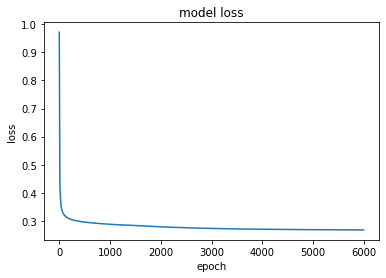

Size: 28759.000000 bits - FPR: 0.759865 



Number of nodes: 9


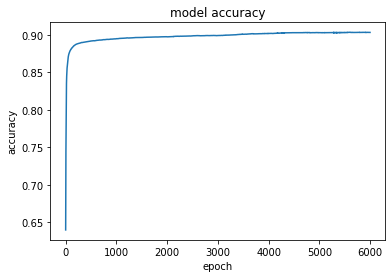

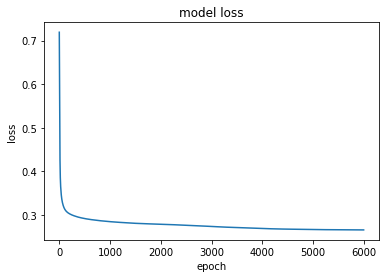

Size: 32349.000000 bits - FPR: 0.566296 



Number of nodes: 10


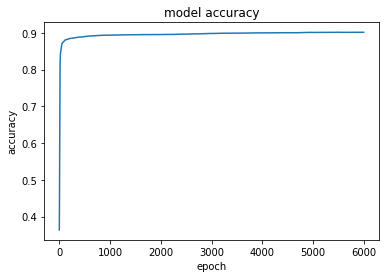

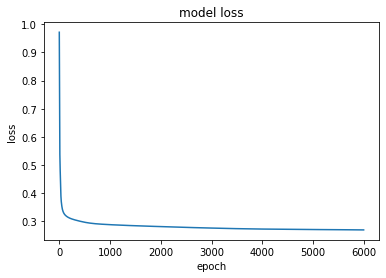

Size: 35940.000000 bits - FPR: 0.736319 



Number of nodes: 11


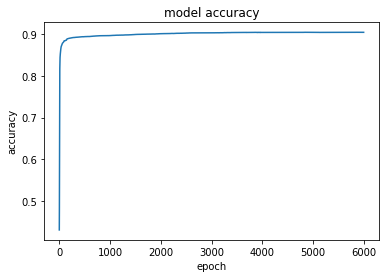

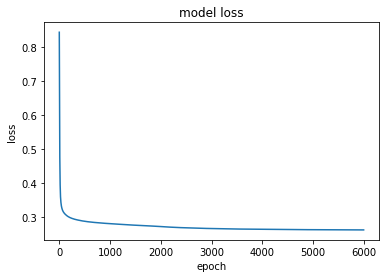

Size: 39530.000000 bits - FPR: 0.515833 



Number of nodes: 12


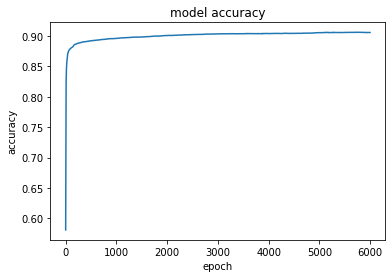

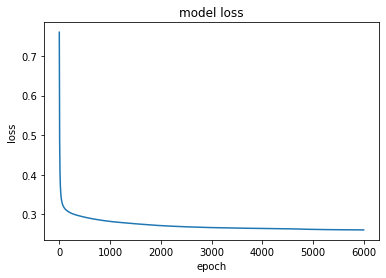

Size: 43121.000000 bits - FPR: 0.478158 



Number of nodes: 13


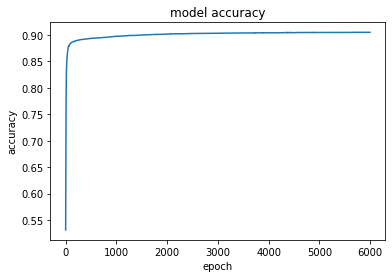

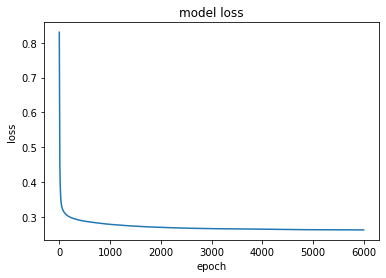

Size: 46711.000000 bits - FPR: 0.648384 



Number of nodes: 14


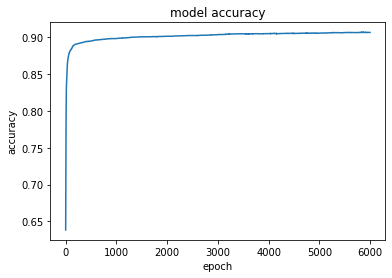

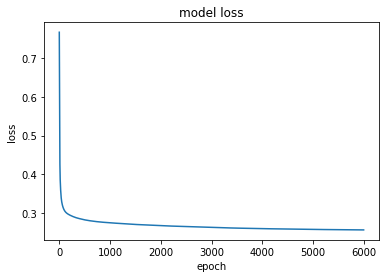

Size: 50301.000000 bits - FPR: 0.441702 



Number of nodes: 15


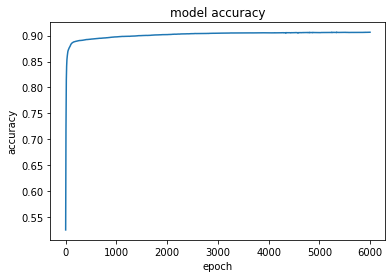

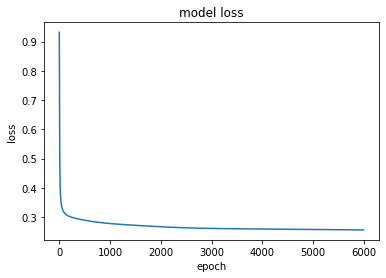

Size: 53892.000000 bits - FPR: 0.609411 



Number of nodes: 16


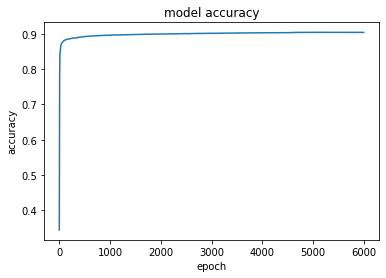

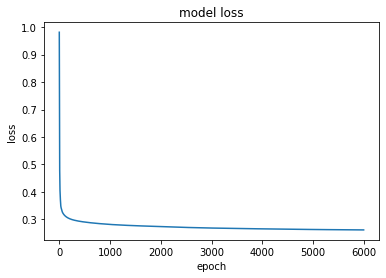

Size: 57482.000000 bits - FPR: 0.598084 



Number of nodes: 17


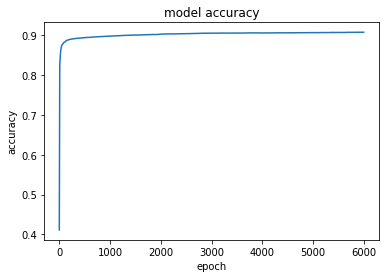

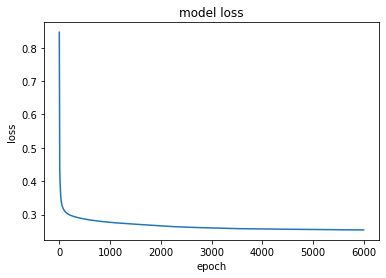

Size: 61073.000000 bits - FPR: 0.360588 



Number of nodes: 18


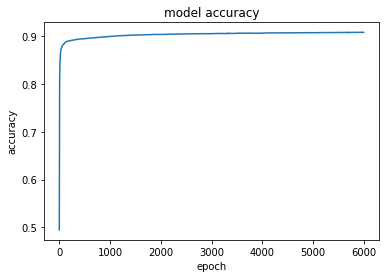

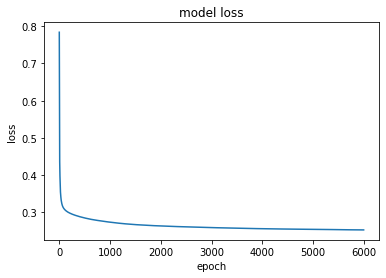

Size: 64663.000000 bits - FPR: 0.368992 



Number of nodes: 19


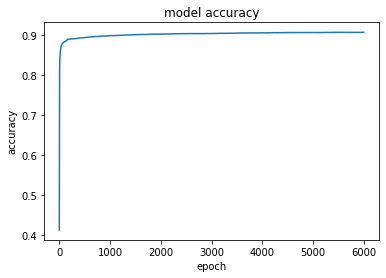

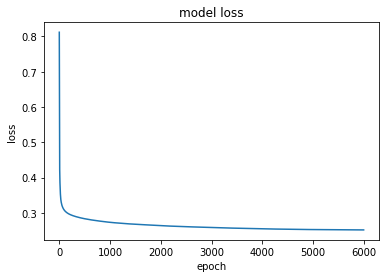

Size: 68253.000000 bits - FPR: 0.358436 



Number of nodes: 20


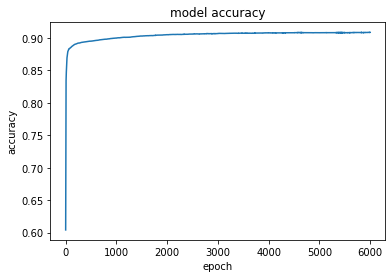

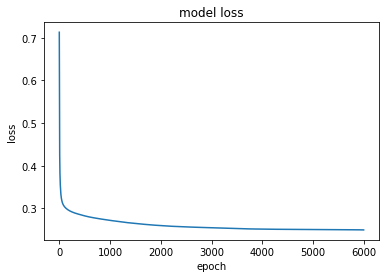

Size: 71844.000000 bits - FPR: 0.338219 





In [20]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values_kraska = []
size_values_kraska = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,20,6000,fpr_values_kraska,size_values_kraska)

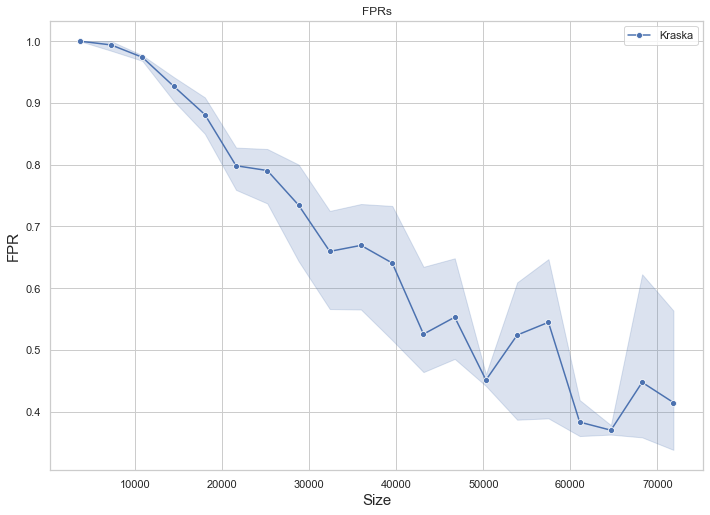

In [21]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",label = "Kraska",linewidth = 1.5,marker="o")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Projection model

In [22]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [23]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [24]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,1000,1500,200,100,fpr_values,size_values)

00 Bits - FPR: 0.368707 



Size: 110500 Bits - FPR: 0.358517 



Size: 112000 Bits - FPR: 0.369195 



Size: 113500 Bits - FPR: 0.368139 



Size: 115000 Bits - FPR: 0.308095 



Size: 116500 Bits - FPR: 0.368261 



Size: 118000 Bits - FPR: 0.337934 



Size: 119500 Bits - FPR: 0.372361 



Size: 121000 Bits - FPR: 0.366799 



Size: 122500 Bits - FPR: 0.337975 



Size: 124000 Bits - FPR: 0.348409 



Size: 125500 Bits - FPR: 0.350763 



Size: 127000 Bits - FPR: 0.336067 



Size: 128500 Bits - FPR: 0.321086 



Size: 130000 Bits - FPR: 0.336879 



Size: 131500 Bits - FPR: 0.332048 



Size: 133000 Bits - FPR: 0.302249 



Size: 134500 Bits - FPR: 0.331195 



Size: 136000 Bits - FPR: 0.335783 



Size: 137500 Bits - FPR: 0.310490 



Size: 139000 Bits - FPR: 0.318245 



Size: 140500 Bits - FPR: 0.301153 



Size: 142000 Bits - FPR: 0.310125 



Size: 143500 Bits - FPR: 0.267579 



Size: 145000 Bits - FPR: 0.245859 



Size: 146500 Bits - FPR: 0.282316 



Size: 148000 Bits - FP

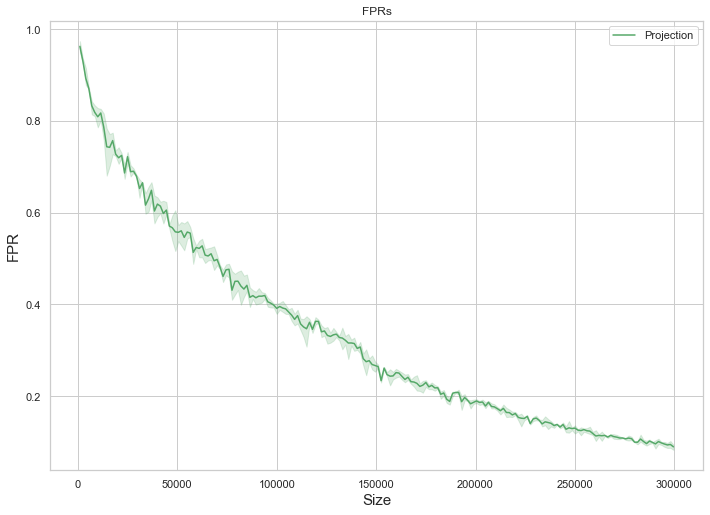

In [25]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Normal Bloom Filter Values

In [26]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [27]:
print(sum(y_train))
print(len(y_train))

49264.0
73896


In [28]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
49264.0


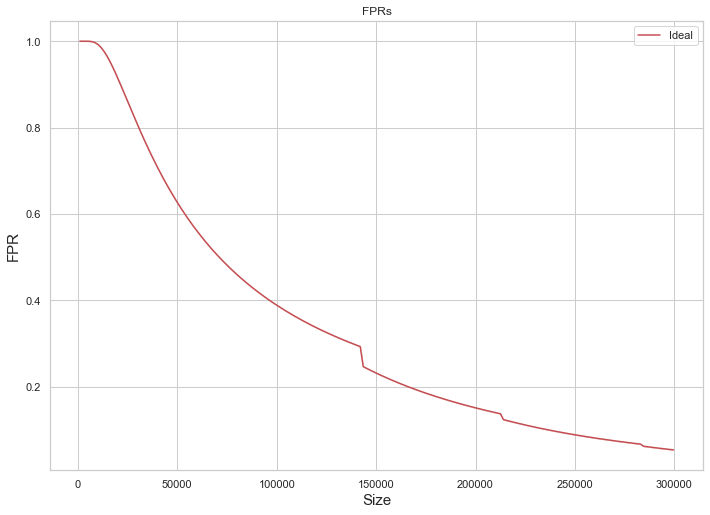

In [29]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

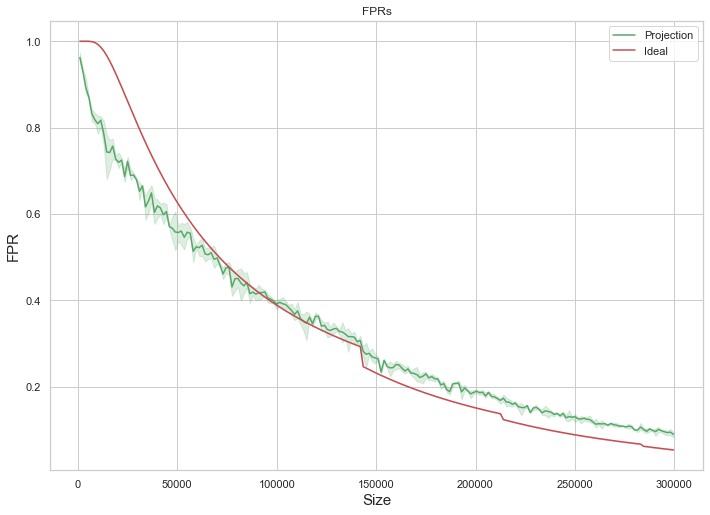

In [30]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [31]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Projection FPR  Ideal FPR
0  1000        0.950633   1.000000
1  2500        0.924570   1.000000
2  4000        0.878167   0.999996
3  5500        0.870047   0.999871
4  7000        0.814063   0.999122

In [32]:
df.to_csv('E:\SURA Data\SatLog_Projection.csv')

# FPR Comparison between all 3 models

In [33]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]

In [34]:
# Ran only once instead of thrice as size_values_kraska already has tripple length
fpr_values_projection = []
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values_projection,size_values_kraska)

(49264, 100)
Size: 3626 Bits - FPR: 0.898871 



Size: 7217 Bits - FPR: 0.848084 



Size: 10807 Bits - FPR: 0.834768 



Size: 14397 Bits - FPR: 0.792059 



Size: 17988 Bits - FPR: 0.753979 



Size: 21578 Bits - FPR: 0.717806 



Size: 25169 Bits - FPR: 0.675341 



Size: 28759 Bits - FPR: 0.667952 



Size: 32349 Bits - FPR: 0.680862 



Size: 35940 Bits - FPR: 0.611116 



Size: 39530 Bits - FPR: 0.621833 



Size: 43121 Bits - FPR: 0.567839 



Size: 46711 Bits - FPR: 0.552817 



Size: 50301 Bits - FPR: 0.542709 



Size: 53892 Bits - FPR: 0.564753 



Size: 57482 Bits - FPR: 0.529555 



Size: 61073 Bits - FPR: 0.530570 



Size: 64663 Bits - FPR: 0.481569 



Size: 68253 Bits - FPR: 0.475114 



Size: 71844 Bits - FPR: 0.478118 



Size: 3626 Bits - FPR: 0.894406 



Size: 7217 Bits - FPR: 0.830870 



Size: 10807 Bits - FPR: 0.811587 



Size: 14397 Bits - FPR: 0.782153 



Size: 17988 Bits - FPR: 0.712285 



Size: 21578 Bits - FPR: 0.729092 



Size: 25169 Bits - FPR: 0.674

In [35]:
n = sum(y_train)
y_ideal_k=[]
for x in size_values_kraska:
    y_ideal_k+=[float(ideal_fpr(x,n))]
print(len(y_ideal_k))
print(n)

60
49264.0


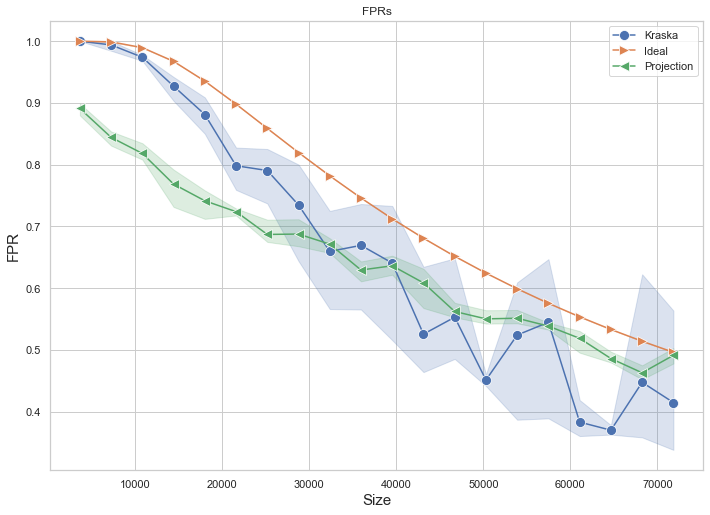

In [36]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values_kraska, y=fpr_values_kraska, err_style="band",marker="o",label = "Kraska",linestyle= "--",markersize=10)
sns.lineplot(x=size_values_kraska, y=y_ideal_k, err_style="band",marker='>',label = "Ideal",linestyle= ":",markersize = 10)
sns.lineplot(x=size_values_kraska, y=fpr_values_projection, err_style="band",marker='<',label = "Projection",linestyle= "-.",markersize = 10)
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [37]:
saved_data = list(zip(size_values_kraska, fpr_values_kraska,fpr_values_projection, y_ideal_k))
df = pd.DataFrame(saved_data,columns = ['Size','Kraska FPR', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Kraska FPR  Projection FPR  Ideal FPR
0   3626    1.000000        0.898871   0.999999
1   7217    1.000000        0.848084   0.998915
2  10807    0.976047        0.834768   0.989525
3  14397    0.936099        0.792059   0.967351
4  17988    0.908980        0.753979   0.935352

In [38]:
df.to_csv('E:\SURA Data\SatLog_Kraska_Projection.csv')

# Projection Model with only 1 Hash Function

In [39]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = 1  #Setting k as 1
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [40]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection(x_train,x_test,y_train,1000,1500,200,100,fpr_values,size_values)

00 Bits - FPR: 0.373538 



Size: 110500 Bits - FPR: 0.360385 



Size: 112000 Bits - FPR: 0.347150 



Size: 113500 Bits - FPR: 0.361481 



Size: 115000 Bits - FPR: 0.370778 



Size: 116500 Bits - FPR: 0.375893 



Size: 118000 Bits - FPR: 0.359816 



Size: 119500 Bits - FPR: 0.359979 



Size: 121000 Bits - FPR: 0.341304 



Size: 122500 Bits - FPR: 0.355594 



Size: 124000 Bits - FPR: 0.348409 



Size: 125500 Bits - FPR: 0.334727 



Size: 127000 Bits - FPR: 0.347921 



Size: 128500 Bits - FPR: 0.343334 



Size: 130000 Bits - FPR: 0.341588 



Size: 131500 Bits - FPR: 0.340857 



Size: 133000 Bits - FPR: 0.331358 



Size: 134500 Bits - FPR: 0.309719 



Size: 136000 Bits - FPR: 0.312520 



Size: 137500 Bits - FPR: 0.316661 



Size: 139000 Bits - FPR: 0.326892 



Size: 140500 Bits - FPR: 0.283980 



Size: 142000 Bits - FPR: 0.305741 



Size: 143500 Bits - FPR: 0.300991 



Size: 145000 Bits - FPR: 0.304685 



Size: 146500 Bits - FPR: 0.313576 



Size: 148000 Bits - FP

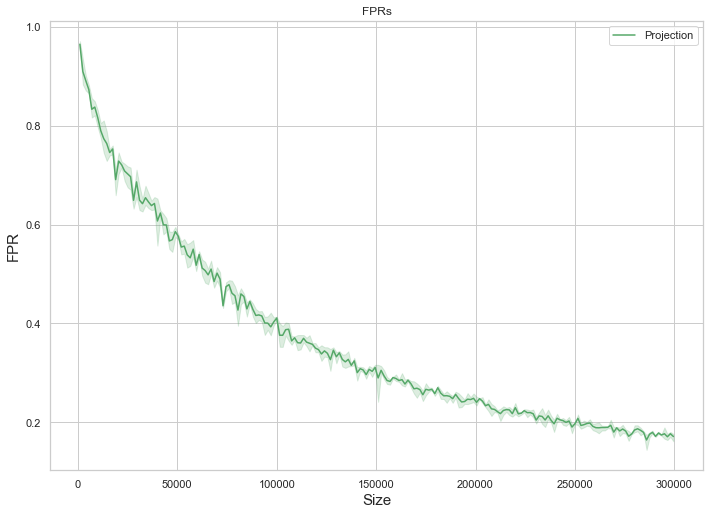

In [41]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

# Comparing new Projection Model with Ideal Bloom Filter

In [42]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
49264.0


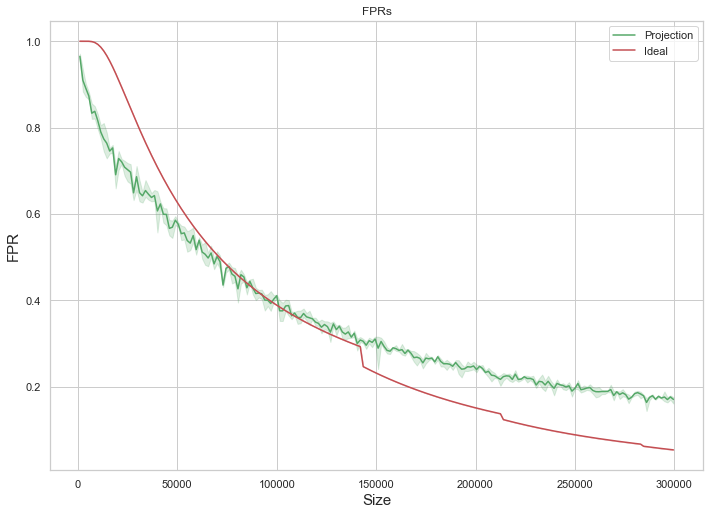

In [43]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [44]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()

Size  Projection FPR  Ideal FPR
0  1000        0.957291   1.000000
1  2500        0.910442   1.000000
2  4000        0.900089   0.999996
3  5500        0.871387   0.999871
4  7000        0.816580   0.999122

In [45]:
df.to_csv('E:\SURA Data\SatLog_Projection1Hash.csv')

# Giving independent bitarrays for each hash function in Projection Model

In [46]:
class Projection_Multiple_Array_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1    
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = (size//hash_count) # Size of each bitarray
        self.hash_count = hash_count
        arrays = []
        for i in range(0,hash_count):
            array = bitarray(size//hash_count)
            array.setall(0)
            arrays += [array]
        self.bit_arrays = arrays

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in range(0,len(hash_values)):
            for j in range(0,self.hash_count):
                self.bit_arrays[j][int(hash_values[i][j])] = 1
            
    def lookup(self, x):
        x = [x]
        hash_values = self.give_hash_values(x)
        for i in range(0,len(hash_values[0])):
            for j in range(0,self.hash_count):
                if(self.bit_arrays[j][int(hash_values[i][j])] == 0):
                    return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(pos_hash_values)):
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(pos_hash_values[i][j])] == 0):
                return -1
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in range(0,len(neg_hash_values)):
        flag = 0
        for j in range(0,bf.hash_count):
            if(bf.bit_arrays[j][int(neg_hash_values[i][j])] == 0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [47]:
def get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
        for j in range(0,epochs):
            bf = Projection_Multiple_Array_BloomFilter(m,k,input_dim)
            bf.bulk_add(x_pos)
            temp = find_fpr(bf,x_pos,x_neg)
            if(fpr>=temp):
                fpr = temp
                tempbf=bf
        fpr_test=find_fpr2(tempbf,x_test)
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [48]:
num_of_iterations = 3 #Increase to make graph smoother

fpr_values = []
size_values = []

for i in range(0,num_of_iterations):
    print("~~~~~~~~ Iteration %d ~~~~~~~~ \n" %(i+1))
    get_data_points_Projection_Multiple_Array(x_train,x_test,y_train,1000,1500,200,100,fpr_values,size_values)

00 Bits - FPR: 0.387139 



Size: 110500 Bits - FPR: 0.387423 



Size: 112000 Bits - FPR: 0.373173 



Size: 113500 Bits - FPR: 0.348449 



Size: 115000 Bits - FPR: 0.376096 



Size: 116500 Bits - FPR: 0.361116 



Size: 118000 Bits - FPR: 0.353524 



Size: 119500 Bits - FPR: 0.356244 



Size: 121000 Bits - FPR: 0.362496 



Size: 122500 Bits - FPR: 0.319503 



Size: 124000 Bits - FPR: 0.349058 



Size: 125500 Bits - FPR: 0.332616 



Size: 127000 Bits - FPR: 0.335864 



Size: 128500 Bits - FPR: 0.312399 



Size: 130000 Bits - FPR: 0.321005 



Size: 131500 Bits - FPR: 0.324456 



Size: 133000 Bits - FPR: 0.332494 



Size: 134500 Bits - FPR: 0.321330 



Size: 136000 Bits - FPR: 0.334321 



Size: 137500 Bits - FPR: 0.288892 



Size: 139000 Bits - FPR: 0.321411 



Size: 140500 Bits - FPR: 0.295997 



Size: 142000 Bits - FPR: 0.331764 



Size: 143500 Bits - FPR: 0.266848 



Size: 145000 Bits - FPR: 0.262220 



Size: 146500 Bits - FPR: 0.259013 



Size: 148000 Bits - FP

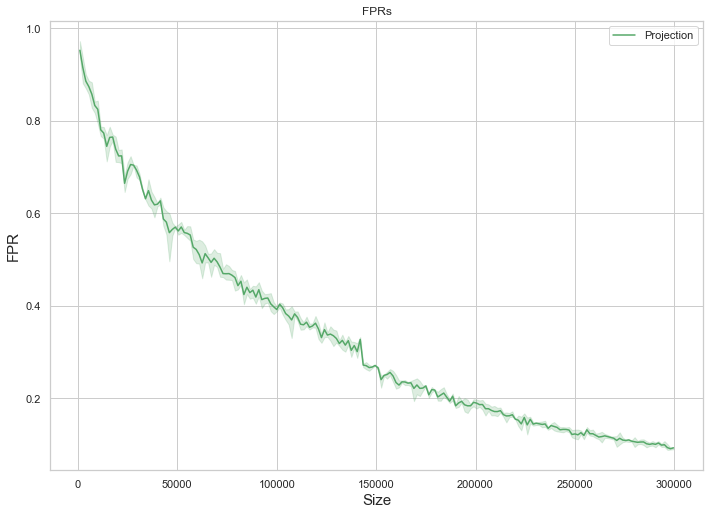

In [49]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [50]:
n = sum(y_train)
y_ideal=[]
for x in size_values:
    y_ideal+=[float(ideal_fpr(x,n))]
print(len(y_ideal))
print(n)

600
49264.0


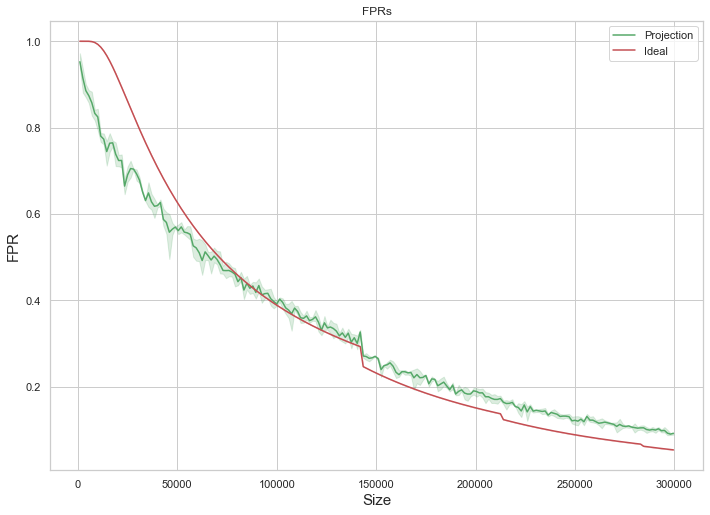

In [51]:
sns.set(rc={'figure.figsize':(11.7,8.27)},style="whitegrid")
sns.lineplot(x=size_values, y=fpr_values, err_style="band",label = "Projection",linewidth = 1.5,color="g")
sns.lineplot(x=size_values, y=y_ideal, err_style="band",label = "Ideal",linewidth = 1.5,color="r")
plt.title('FPRs')
plt.xlabel("Size", fontsize = 15)
plt.ylabel("FPR", fontsize = 15)
#plt.figure(figsize = (5000,5000))
plt.show()

In [52]:
saved_data = list(zip(size_values, fpr_values, y_ideal))
df = pd.DataFrame(saved_data,columns = ['Size', 'Projection FPR', 'Ideal FPR'])
df.head()
df.to_csv('E:\SURA Data\SatLog_ProjectionDiffBitarrays.csv')